<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [ ]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

#for histogram
import matplotlib.pyplot as plt
from collections import Counter

#nltk
import nltk 
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Spacy
import spacy


#Dataset
from sklearn.datasets import fetch_20newsgroups


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load Data into Dataframe

In [ ]:
#method that converts data to csv file
# def twenty_newsgroup_data_to_csv():
#     news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

#     df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
#     df.columns = ['text', 'target']

#     targets = pd.DataFrame( news_group_data.target_names)
#     targets.columns=['title']

#     out = pd.merge(df, targets, left_on='target', right_index=True)
#     out.to_csv('20_newsgroup.csv')
# twenty_newsgroup_data_to_csv()

In [ ]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup_sample.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)

In [ ]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1463
text          1463
target        1463
title         1463
dtype: int64


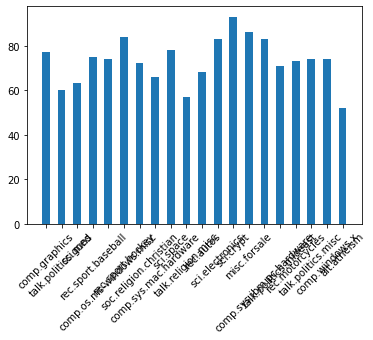

In [ ]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [ ]:
print(counter)

Counter({'sci.crypt': 93, 'misc.forsale': 86, 'rec.sport.hockey': 84, 'sci.electronics': 83, 'comp.sys.ibm.pc.hardware': 83, 'sci.space': 78, 'comp.graphics': 77, 'rec.sport.baseball': 75, 'comp.os.ms-windows.misc': 74, 'talk.politics.misc': 74, 'comp.windows.x': 74, 'rec.motorcycles': 73, 'soc.religion.christian': 72, 'talk.politics.mideast': 71, 'rec.autos': 68, 'comp.sys.mac.hardware': 66, 'sci.med': 63, 'talk.politics.guns': 60, 'talk.religion.misc': 57, 'alt.atheism': 52})


## Pre-process the data

Lemmatization to get base words

In [ ]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [ ]:
dataset['news_lemma_text']=lemmatization(dataset['text'])

In [ ]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...


Remove Stopword

In [ ]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [ ]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_lemma_text'])

In [ ]:
dataset.head(10)


,Unnamed: 0,text,target,title,news_lemma_text,news_tokens
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...,"[like, reference, algorithm, detect, closed, c..."
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ..."
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...,"[back, look, review, claim, significant, diffe..."
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...,"[accord, version, number, choose, deep, philos..."
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...,"[majority, user, readde, cd, rom, like, fast, ..."
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...,"[spend, money, time, need, find, base, softwar..."
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon,"[agree, try, daemon]"
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available,"[file, format, available]"
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...,"[bio, support, mode, vga, able, support, color..."
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...,"[post, mpeg, decoder, player, short, descripti..."


In [ ]:
def joinTokens(texts):
  texts_out = []
  for text in texts:
    new_text = []
    for token in text:
            new_text.append(token)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [ ]:
dataset['news_joined_text']=joinTokens(dataset['news_tokens'])

In [ ]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...,"[like, reference, algorithm, detect, closed, c...",like reference algorithm detect closed curve b...
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ...",recently instal system base non linear full di...
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...,"[back, look, review, claim, significant, diffe...",back look review claim significant difference ...
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...,"[accord, version, number, choose, deep, philos...",accord version number choose deep philosophica...
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...,"[majority, user, readde, cd, rom, like, fast, ...",majority user readde cd rom like fast work wel...
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...,"[spend, money, time, need, find, base, softwar...",spend money time need find base software conto...
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon,"[agree, try, daemon]",agree try daemon
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available,"[file, format, available]",file format available
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...,"[bio, support, mode, vga, able, support, color...",bio support mode vga able support color requir...
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...,"[post, mpeg, decoder, player, short, descripti...",post mpeg decoder player short description tec...


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000)
X = vectorizer.fit_transform(dataset['news_joined_text'])
words = np.array(vectorizer.get_feature_names())

print(X)
#print("X = ", words)

  (0, 908)	0.28949595438995107
  (0, 166)	0.4359812133525767
  (0, 490)	0.4172743278024563
  (0, 594)	0.3115847387464016
  (0, 27)	0.4421353163611702
  (0, 734)	0.4148955437909331
  (0, 493)	0.2954447659063283
  (1, 89)	0.06569101982055812
  (1, 420)	0.07176951993825627
  (1, 635)	0.0691120864293959
  (1, 294)	0.041512606125460136
  (1, 147)	0.07580929958913729
  (1, 618)	0.07011554996157862
  (1, 72)	0.0472063557530188
  (1, 809)	0.05104408135073805
  (1, 561)	0.06531653057634136
  (1, 259)	0.052900105380577475
  (1, 927)	0.06772974028737526
  (1, 445)	0.07364463644475587
  (1, 951)	0.06203599065981658
  (1, 729)	0.07505005985478105
  (1, 793)	0.03836554849173868
  (1, 296)	0.056342241032257906
  (1, 267)	0.059378557150956204
  (1, 319)	0.06531653057634136
  :	:
  (1462, 886)	0.09646744688902942
  (1462, 125)	0.12725178886943506
  (1462, 457)	0.09721079697492054
  (1462, 860)	0.10246616631085197
  (1462, 621)	0.13325050829125765
  (1462, 610)	0.1127620634967007
  (1462, 427)	0.0919765

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# default method in sklearn
from sklearn.decomposition import NMF
 
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: good,come,way,take,many,believe,see,thing,know,people
Topic 2: help,memory,display,work,get,server,program,application,run,window
Topic 3: baseball,good,last,year,win,season,play,player,game,team
Topic 4: send,email,address,reply,appreciate,know,post,advance,mail,thank
Topic 5: agency,public,phone,security,algorithm,system,escrow,encryption,chip,key
Topic 6: ask,printer,list,interested,sale,offer,include,shipping,sell,price
Topic 7: point,directory,shareware,read,find,write,image,available,format,file
Topic 8: bus,cable,instal,monitor,meg,controller,pin,hard,disk,drive
Topic 9: pull,oil,engine,mile,take,get,buy,bike,know,car
Topic 10: could,agree,figure,newsgroup,see,list,want,post,try,may
Topic 11: address,start,interested,good,work,give,email,also,problem,look
Topic 12: read,name,guy,must,build,buy,mean,even,still,think
Topic 13: motherboard,buy,slot,bit,graphic,color,monitor,video,system,card
Topic 14: weapon,criminal,act,kill,power,people,law,right,gun,government
Topic 15:

In [ ]:
#Dataframe for all the words with each topic
components_df = pd.DataFrame(H, columns=vectorizer.get_feature_names())
components_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,abuse,academic,accept,access,accord,account,act,action,active,...,word,work,world,worth,write,wrong,xfree,year,yet,young
0,9.717313e-02,6.434443e-02,2.196208e-12,9.606027e-02,0.000026,6.547469e-02,7.998232e-02,9.107293e-02,9.981713e-02,2.100773e-02,...,1.440885e-01,0.087215,2.451267e-01,3.152239e-02,0.157767,0.110499,2.126736e-07,2.437499e-02,0.085069,7.305852e-02
1,2.723710e-02,0.000000e+00,1.658384e-03,0.000000e+00,0.199882,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.697709e-02,...,0.000000e+00,0.373671,0.000000e+00,1.321086e-07,0.104767,0.000000,3.390216e-02,0.000000e+00,0.000000,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,3.917654e-03,0.000000,0.000000,0.000000e+00,4.605172e-01,0.036438,1.657962e-02
3,0.000000e+00,0.000000e+00,2.812012e-03,0.000000e+00,0.000000,0.000000e+00,3.079315e-04,4.114477e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,4.903355e-12,0.000000e+00,0.015449,0.000000,0.000000e+00,1.085790e-12,0.000028,3.298908e-17
4,0.000000e+00,1.083186e-02,5.648082e-03,0.000000e+00,0.108170,0.000000e+00,4.285468e-04,0.000000e+00,5.077252e-03,0.000000e+00,...,3.698607e-03,0.057662,0.000000e+00,0.000000e+00,0.000002,0.000000,5.145201e-14,2.340793e-09,0.031230,0.000000e+00
5,3.188869e-04,7.220389e-08,4.652224e-05,0.000000e+00,0.012898,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.339953e-11,...,0.000000e+00,0.000000,1.517100e-02,2.062760e-02,0.000000,0.000000,0.000000e+00,2.950493e-13,0.000000,0.000000e+00
6,0.000000e+00,0.000000e+00,8.047958e-03,3.435626e-08,0.063912,1.017077e-09,8.764535e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,2.292160e-02,0.000000,1.000691e-05,4.830215e-03,0.232172,0.000000,3.485521e-02,0.000000e+00,0.000000,0.000000e+00
7,6.369952e-02,4.596102e-21,0.000000e+00,6.935200e-03,0.110144,0.000000e+00,0.000000e+00,6.492784e-16,0.000000e+00,0.000000e+00,...,5.443202e-03,0.000000,1.816218e-03,4.455302e-02,0.000000,0.000000,0.000000e+00,1.520078e-11,0.006512,1.535644e-26
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.167440e-10,...,0.000000e+00,0.000000,0.000000e+00,3.370241e-02,0.000000,0.000000,0.000000e+00,4.829691e-03,0.011727,5.377056e-07
9,1.347490e-02,0.000000e+00,0.000000e+00,1.105840e-11,0.011193,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,1.692975e-03,0.000000,0.002044,0.000000e+00,0.000000e+00,0.000000,0.000000e+00


In [ ]:
#save topics in arrays
feature_names = vectorizer.get_feature_names()
twords={}
for topic_idx, topic in enumerate(nmf.components_):
    arr=[]
    arr.append([feature_names[i]
                    for i in topic.argsort()[:-10 - 1:-1]])
    twords[topic_idx]=arr
print(twords)

{0: [['people', 'know', 'thing', 'see', 'believe', 'many', 'take', 'way', 'come', 'good']], 1: [['window', 'run', 'application', 'program', 'server', 'get', 'work', 'display', 'memory', 'help']], 2: [['team', 'game', 'player', 'play', 'season', 'win', 'year', 'last', 'good', 'baseball']], 3: [['thank', 'mail', 'advance', 'post', 'know', 'appreciate', 'reply', 'address', 'email', 'send']], 4: [['key', 'chip', 'encryption', 'escrow', 'system', 'algorithm', 'security', 'phone', 'public', 'agency']], 5: [['price', 'sell', 'shipping', 'include', 'offer', 'sale', 'interested', 'list', 'printer', 'ask']], 6: [['file', 'format', 'available', 'image', 'write', 'find', 'read', 'shareware', 'directory', 'point']], 7: [['drive', 'disk', 'hard', 'pin', 'controller', 'meg', 'monitor', 'instal', 'cable', 'bus']], 8: [['car', 'know', 'bike', 'buy', 'get', 'take', 'mile', 'engine', 'oil', 'pull']], 9: [['may', 'try', 'post', 'want', 'list', 'see', 'newsgroup', 'figure', 'agree', 'could']], 10: [['look'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


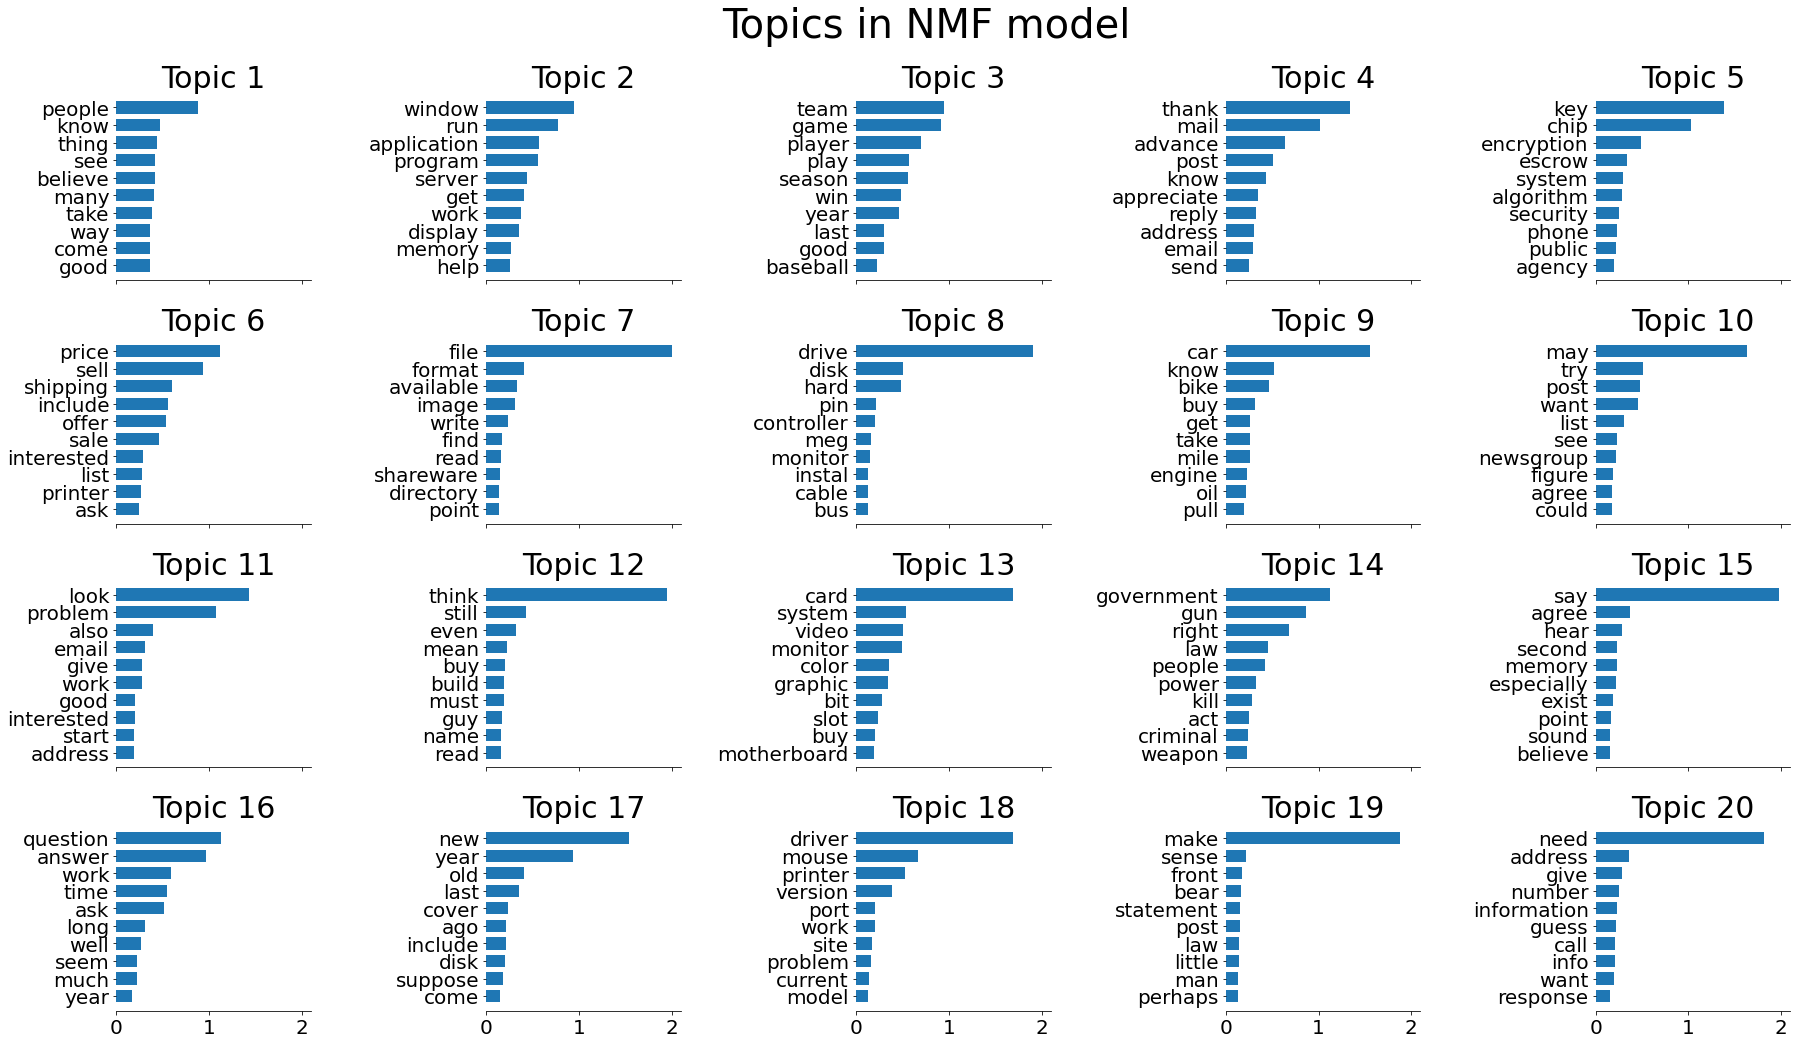

In [ ]:
n_components = 20
n_top_words = 10


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




tfidf_feature_names =vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model")


## Best Topic

In [ ]:
def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return(sub_li)

def best_topic():
  num=0
  arr =[]
  topicWords =[]
  for x in W:
    topic = np.argmax(x, axis=0)
    print("For Doc #",num,"the best topic is", topic)
    arr.append(topic)
    topicWords.append(twords.get(topic))
    num =num+1

  dataset['best_topic_nmf']=arr
  dataset['best_topic_nmf_words']=topicWords

best_topic()


For Doc # 0 the best topic is 3
For Doc # 1 the best topic is 12
For Doc # 2 the best topic is 6
For Doc # 3 the best topic is 14
For Doc # 4 the best topic is 6
For Doc # 5 the best topic is 19
For Doc # 6 the best topic is 9
For Doc # 7 the best topic is 6
For Doc # 8 the best topic is 12
For Doc # 9 the best topic is 1
For Doc # 10 the best topic is 10
For Doc # 11 the best topic is 6
For Doc # 12 the best topic is 12
For Doc # 13 the best topic is 1
For Doc # 14 the best topic is 6
For Doc # 15 the best topic is 6
For Doc # 16 the best topic is 1
For Doc # 17 the best topic is 11
For Doc # 18 the best topic is 6
For Doc # 19 the best topic is 12
For Doc # 20 the best topic is 6
For Doc # 21 the best topic is 6
For Doc # 22 the best topic is 9
For Doc # 23 the best topic is 6
For Doc # 24 the best topic is 19
For Doc # 25 the best topic is 1
For Doc # 26 the best topic is 11
For Doc # 27 the best topic is 12
For Doc # 28 the best topic is 6
For Doc # 29 the best topic is 19
For Doc 

In [ ]:
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_nmf,best_topic_nmf_words
724,649,I told some friends of mine two weeks ago that...,19,talk.religion.misc,tell friend mine week ago dead BATF could let ...,"[tell, friend, mine, week, ago, dead, batf, co...",tell friend mine week ago dead batf could let ...,0,"[[people, know, thing, see, believe, many, tak..."
1234,11200,Does anyone have a rear wheel for a PD they'd ...,8,rec.motorcycles,rear wheel would like part know where may find...,"[rear, wheel, like, part, know, may, find, sal...",rear wheel like part know may find salvage lon...,9,"[[may, try, post, want, list, see, newsgroup, ..."
1003,927,Storage space for sale:\n \n Iomega 44 M...,6,misc.forsale,storage space sale mb removeable hd sale cartr...,"[storage, space, sale, removeable, sale, cartr...",storage space sale removeable sale cartridge t...,5,"[[price, sell, shipping, include, offer, sale,..."
878,6452,The title says it all. Contact me via EMAIL i...,12,sci.electronics,title say contact email would can help know be...,"[title, say, contact, email, can, help, know, ...",title say contact email can help know want lik...,5,"[[price, sell, shipping, include, offer, sale,..."
1430,4895,"\nAnd seen from my point of view, I get far to...",5,comp.windows.x,see point view get far too much article keep l...,"[see, point, view, get, far, much, keep, lucky...",see point view get far much keep lucky scan ti...,15,"[[question, answer, work, time, ask, long, wel..."
552,3523,\n\tHey what does the A/Rose extension do anyw...,4,comp.sys.mac.hardware,a extension anyway,"[extension, anyway]",extension anyway,15,"[[question, answer, work, time, ask, long, wel..."
638,6817,This is turning into 'what's a moonbase good f...,14,sci.space,turn moonbase good ought post when odd post go...,"[turn, moonbase, good, ought, post, odd, post,...",turn moonbase good ought post odd post think r...,11,"[[think, still, even, mean, buy, build, must, ..."
44,3947,\nBy '8 grey level images' you mean 8 items of...,1,comp.graphics,grey level image mean item image work work mor...,"[grey, level, image, mean, item, image, work, ...",grey level image mean item image work work scr...,1,"[[window, run, application, program, server, g..."
414,9051,"\n\n[stuff deleted...]\n\n \nAs I recall, the...",10,rec.sport.hockey,stuff delete recall author original article st...,"[stuff, delete, recall, author, original, star...",stuff delete recall author original start thre...,11,"[[think, still, even, mean, buy, build, must, ..."
819,4525,I have a new scope and I thought I'd save a fe...,12,sci.electronics,new scope think would save few buck buy functi...,"[new, scope, think, save, buck, buy, function,...",new scope think save buck buy function generat...,0,"[[people, know, thing, see, believe, many, tak..."


## Cosine Similarity

In [ ]:
# get original topic words
dataset['target_topic_word']= dataset['title'].str.split('.')
dataset.sample(5)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_nmf,best_topic_nmf_words,target_topic_word
166,5720,\nIn fact Adiposity 101 mentions a similar stu...,13,sci.med,fact mention similar study search life event r...,"[fact, mention, similar, study, search, life, ...",fact mention similar study search life event r...,0,"[[people, know, thing, see, believe, many, tak...","[sci, med]"
323,10616,Thanks for the info. I assume that this is fo...,2,comp.os.ms-windows.misc,thank info assume know will work else need do ...,"[thank, info, assume, know, work, else, need, ...",thank info assume know work else need thank,3,"[[thank, mail, advance, post, know, appreciate...","[comp, os, ms-windows, misc]"
112,1562,\nI will join the ranks here. If someone has ...,16,talk.politics.guns,will join rank here ability actually put thing...,"[join, rank, ability, actually, put, thing, to...",join rank ability actually put thing together ...,0,"[[people, know, thing, see, believe, many, tak...","[talk, politics, guns]"
1022,5582,"5.25"" Internal Low density disk drive.\n\nMono...",6,misc.forsale,density disk drive monitor motherboard build p...,"[density, disk, drive, monitor, motherboard, b...",density disk drive monitor motherboard build p...,7,"[[drive, disk, hard, pin, controller, meg, mon...","[misc, forsale]"
293,4839,On ftp.cica.indiana.edu in pub/pc/win3/misc/wi...,2,comp.os.ms-windows.misc,writeup number other benchmark result isa vide...,"[writeup, number, benchmark, result, isa, vide...",writeup number benchmark result isa video card...,12,"[[card, system, video, monitor, color, graphic...","[comp, os, ms-windows, misc]"


In [ ]:
#cosine similarity
from collections import Counter

def cosine_similarity(x,num):
   a_vals = Counter(x)
   b_vals = Counter(y)
   words = list(set(a_vals) | set(b_vals))
   # convert to word-vectors
   a_vect = [a_vals.get(s, 0) for s in words]
   b_vect = [b_vals.get(s, 0) for s in words] 

  # find cosine
   len_a  = sum(av*av for av in a_vect) ** 0.5 
   len_b  = sum(bv*bv for bv in b_vect) ** 0.5   
   dot = sum(av*bv for av,bv in zip(a_vect, b_vect)) 
   if len_a == 0 or len_b == 0 :
    cosine = 1
   else:
    cosine = dot / (len_a * len_b)     
   return cosine

arr =[]
num =0
for x in dataset['best_topic_nmf_words']:
  y = dataset['target_topic_word'].values[num]
  arr.append(cosine_similarity(x[0],y))
  num = num +1

print("The average cosine similarity is:", np.mean(arr))

The average cosine similarity is: 0.006569200169217878


## Other versions of NMF

In [ ]:
nmfV = NMF(
    n_components=20,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


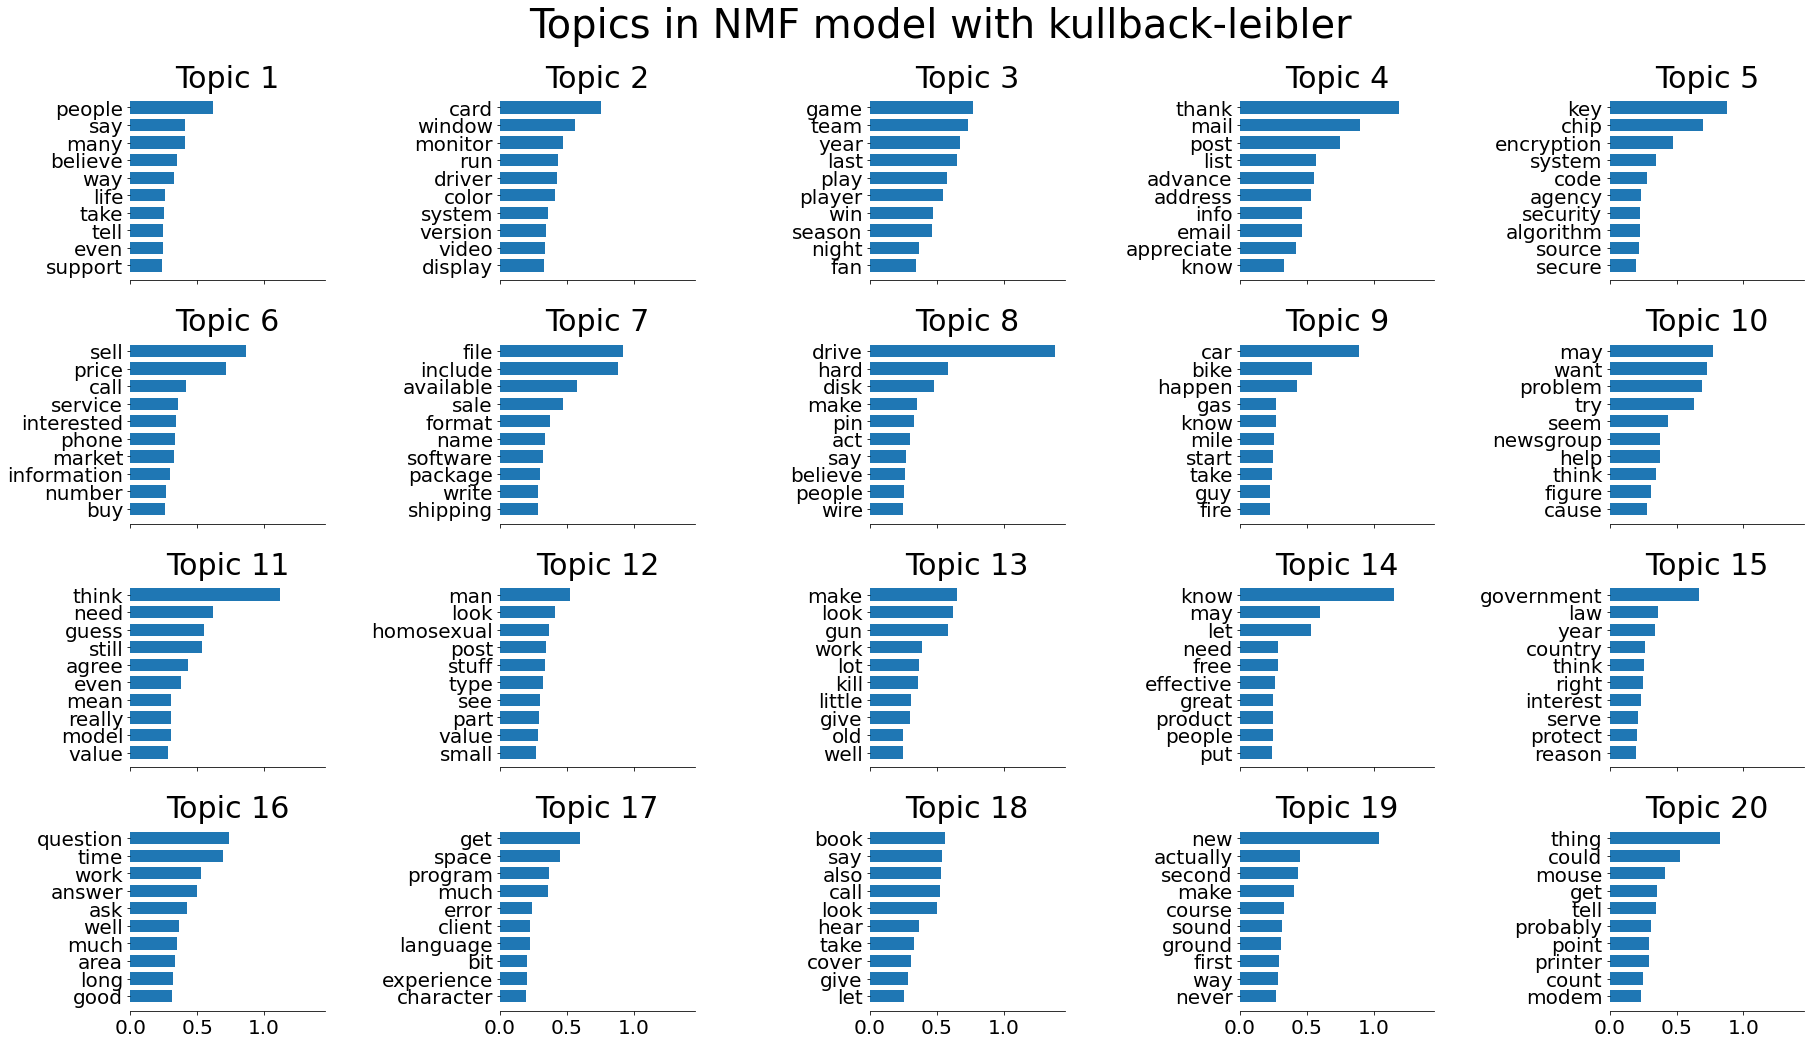

In [ ]:
plot_top_words(nmfV, tfidf_feature_names, n_top_words, "Topics in NMF model with kullback-leibler")